In [1]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

import smfret.fit as fit

from smfret.tf_layers import Attention
from smfret.tf_layers import Conv
from smfret.tf_layers import Summary
from smfret.tf_layers import PrependTaskToken
from smfret.tf_layers import Embedding
from smfret.tf_layers import PositionEmbedding

from smfret.trace_simulator import Simulator
from smfret.trace_simulator import ParameterGenerator
from smfret.trace_simulator import SimulatedTraceSet

from smfret.multi_task_learning import FRETStateTraceSet
from smfret.multi_task_learning import TwoStateQuickDynamicTraceSet
from smfret.dataset import MatlabTraceSet

from sklearn.manifold import TSNE
from sklearn import metrics

import functools

from sciplotlib import style as spstyle

In [2]:
rng = np.random.default_rng()

In [3]:
keras.mixed_precision.set_global_policy('mixed_bfloat16')
encoder = keras.models.load_model('saved_models/best_model/encoder-20240111-045226.h5', compile=False)

In [4]:
def interpolate_position_embedding(position_embedding, periodicity=40):
    """Interpolates the position embedding vectors."""
    vectors = []
    w = position_embedding.variables[0]
    for i in range(w.shape[0]):
        if i == 0:
            vectors.append(w[i, :])
        elif i < periodicity:
            vectors.append(w[i, :])
        else:
            vectors.append(w[i - periodicity + 1, :])
    position_embedding.variables[0].assign(tf.stack(vectors, axis=0))

In [5]:
position_embedding = encoder.layers[-1].transformer.position_embedding
interpolate_position_embedding(position_embedding, periodicity=40)

In [6]:
NN_K = 1  # how many nearest neighbors are considered for the score

In [7]:
def calculate_distance(embedding):
    """Calculates the distance matrix from the embeddings."""
    distance = (
        tf.expand_dims(tf.einsum('ik,ik->i', embedding, embedding), axis=-1)
        + tf.expand_dims(tf.einsum('ik,ik->i', embedding, embedding), axis=0)
        - 2.0 * tf.einsum('ik,jk->ij', embedding, embedding))
    return distance

In [8]:
def get_consistency_coeff(embedding, label, branching_factor, target_label=True, use_excess_definition=True, normalize=True):
    """Calculates the percentage that selected trace's KNNs are also selected.""" 
    distance = calculate_distance(embedding)
    top_k_results = tf.math.top_k(
        -distance, k=branching_factor + 1, sorted=True, name=None
    )
    top_k_idx = top_k_results.indices.numpy()
    selected_labels = (label == target_label)
    top_k_labels = label[top_k_idx[selected_labels, 1:].flatten()]
    p_e = np.mean(label == target_label)
    # return (np.mean(top_k_labels == target_label) - p_e) / (1.0 - p_e)
    if use_excess_definition:
        if normalize:
            return (np.mean(top_k_labels == target_label) - p_e) / (1.0 - p_e)
        else:
            return np.mean(top_k_labels == target_label) - p_e
    else:
        return np.mean(top_k_labels == target_label)

In [9]:
# Manuscript's order: 'DNA Walker', 'DNA Swinging Arm', 'PreQ 1', 'Transcriptional Complex', 'RiboSwitch'

run_config = [
    {
        "config_file": 'experiment_conditions/cond4.json',
        "output_dir": '/Users/leyou/Desktop/Github/metasim-datasets/dna_walker/',
    },
    {
        "config_file": 'experiment_conditions/cond2.json',
        "output_dir": '/Users/leyou/Desktop/Github/metasim-datasets/dna_swinging_arm/',
    },
    {
        "config_file": 'experiment_conditions/cond5.json',
        "output_dir": '/Users/leyou/Desktop/Github/metasim-datasets/preQ_1/',
    },
    {
        "config_file": 'experiment_conditions/cond3.json',
        "output_dir": '/Users/leyou/Desktop/Github/metasim-datasets/transcriptional_complex/',
    },
    {
        "config_file": 'experiment_conditions/cond1.json',
        "output_dir": '/Users/leyou/Desktop/Github/metasim-datasets/riboswitch/',
    },
]

In [21]:
def generate_embedding_and_label(trace_sets, start_frame, encoder, max_frame=2000, max_traces=4000, balance_labels=True):
    """Generates the embeddings and labels."""

    embeddings = []
    labels = []
    colors = []
    color_count = 1
    image_files = []
    traces = []
    
    count = 0
    for trace_set in trace_sets:
        trim_size = len(trace_set.time) // 1000 * 1000
        trace_set.trim(trim_size)
        trace_set.trim(max_frame, start_frame=start_frame)
        trace_set.broadcast_data_to_traces()
        print(trace_set.size)
        if count + trace_set.size > max_traces:
            break
        else:
            count += trace_set.size
                
        with tf.device('/CPU:0'):
            label = np.max(trace_set.label, axis=-1)
            if balance_labels:
                n_included = np.sum(label == 1)
                n_excluded = np.sum(label == 0)
                if n_included == 0 or n_excluded == 0:
                    continue
                indices = np.arange(len(label))
                ratio = int(n_excluded / n_included)
                if ratio > 1:
                    indices = np.concatenate([indices[label == 1], indices[label ==0][::ratio]])
                    label = label[indices]
                    trace_set = trace_set.get_subset(indices)

            embedding = encoder.predict(trace_set.to_tensor(), batch_size=8)
            embeddings.append(embedding)
            labels.append(label)
            traces.extend(trace_set.traces)
    return embeddings, labels

In [28]:
scores = {}
for run in run_config:
    scores[run['output_dir']] = []
    with open(run['config_file']) as f:
        config = json.load(f)
    trace_sets = [MatlabTraceSet(file) for file in config['expt_setting_set_files'].strip().split('\n')]
    embeddings, labels = generate_embedding_and_label(trace_sets, config['start_frame'], encoder, max_frame=4000, max_traces=20000)
    for embedding, label in zip(embeddings, labels):
        score = get_consistency_coeff(embedding, label, branching_factor=NN_K, use_excess_definition=False)
        scores[run['output_dir']].append(score)

945
3/3 [==============================] - 0s 124ms/step
830
3/3 [==============================] - 0s 99ms/step
818
5/5 [==============================] - 1s 126ms/step
821
5/5 [==============================] - 1s 124ms/step
662
3/3 [==============================] - 0s 114ms/step
948
2/2 [==============================] - 0s 127ms/step
773
7/7 [==============================] - 1s 122ms/step
594
3/3 [==============================] - 0s 115ms/step
669
3/3 [==============================] - 0s 127ms/step
748
3/3 [==============================] - 0s 111ms/step
767
3/3 [==============================] - 0s 80ms/step
596
6/6 [==============================] - 1s 119ms/step
837
8/8 [==============================] - 1s 130ms/step
768
7/7 [==============================] - 1s 130ms/step
771
7/7 [==============================] - 1s 115ms/step
753
5/5 [==============================] - 1s 131ms/step
626
7/7 [==============================] - 1s 121ms/step
607
7/7 [========================

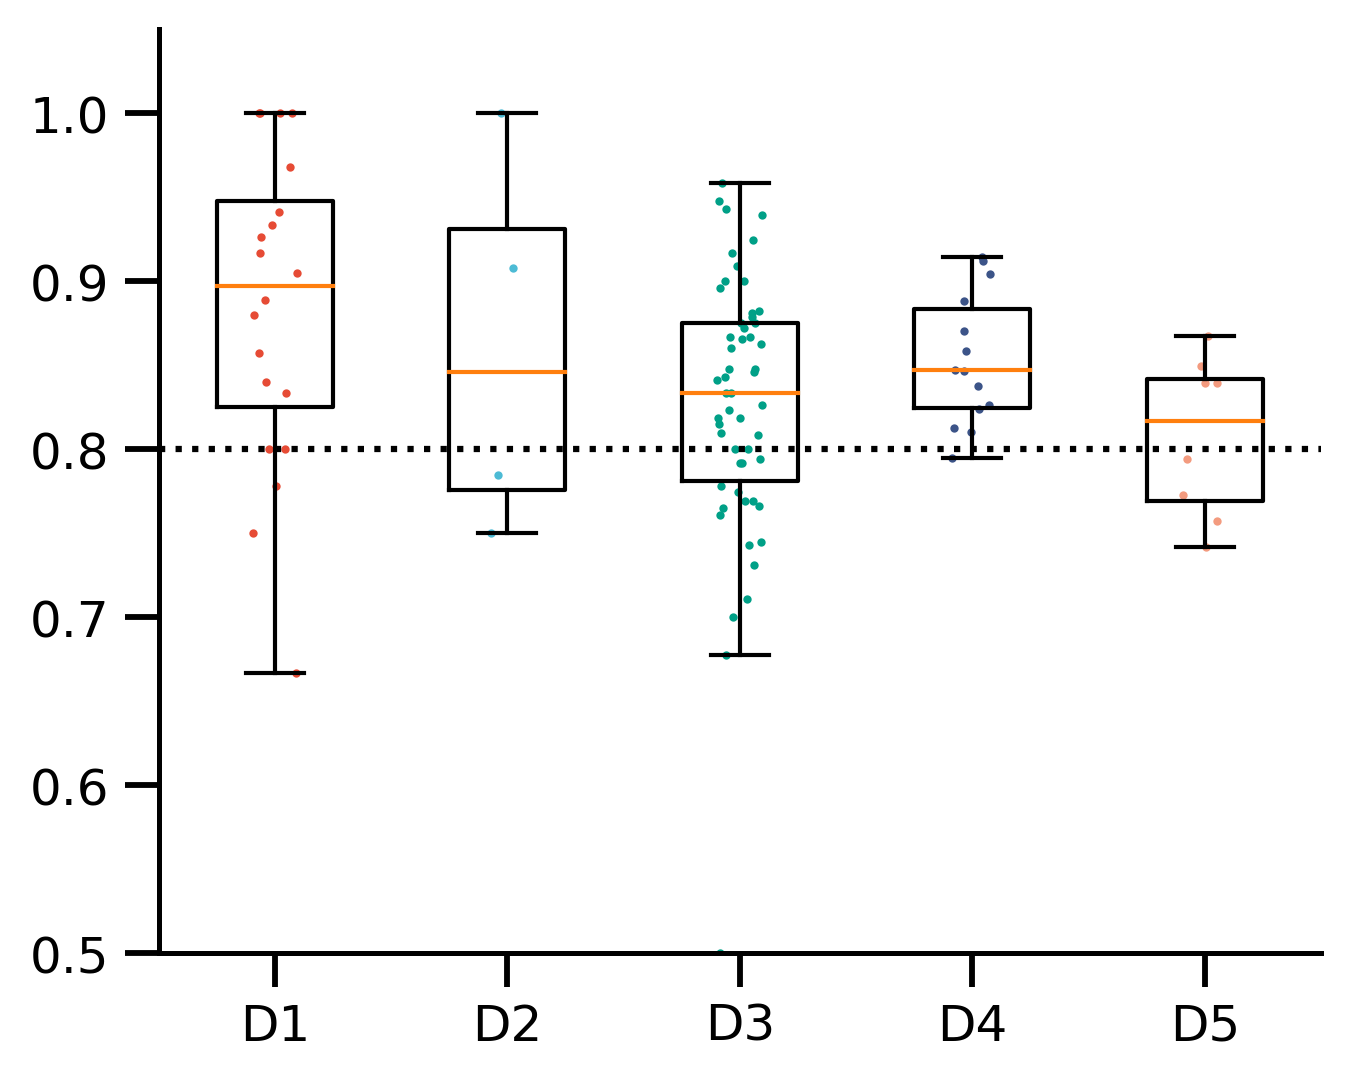

In [38]:
all_data = []
labels = []

np.random.seed(42)
with plt.style.context(spstyle.get_style('nature-reviews')):
    plt.figure(figsize=(5, 4))
    for i, run in enumerate(run_config):
        data = scores[run['output_dir']]
        labels.append(f'D{i+1}')
        all_data.append(data)
        x = [i + 1 + np.random.uniform(-0.1, 0.1) for _ in range(1, len(data) + 1)]
        plt.plot(x, data, 'o', alpha=1, markersize=2, markeredgewidth=0.0)  # Plot points with transparency
    
# Create the boxplot
bp = plt.boxplot(all_data, showfliers=False)
plt.axhline(0.8, linestyle=':', color='black')
plt.ylim([0.5, 1.05])
plt.xticks(np.arange(len(labels)) + 1, labels)
# plt.xlabel('Dataset')
# plt.ylabel('Self-consistency\nscore')
plt.savefig('figures/fig4-self-consistency-score-dist.svg', transparent=True)

In [44]:
measure = {}
n_linear = 100
for run in run_config:
    with open(run['config_file']) as f:
        config = json.load(f)
    trace_sets = [MatlabTraceSet(file) for file in config['expt_setting_set_files'].strip().split('\n')]
    embeddings, labels = generate_embedding_and_label(trace_sets, config['start_frame'], encoder, max_frame=4000, max_traces=20000)
    measure[run['output_dir']] = []
    for embedding, label in zip(embeddings, labels):
        sample_measure = []
        idx = np.random.permutation(np.arange(len(label)))
        embedding, label = embedding[idx], label[idx]
        for n_sample in np.linspace(2, len(label), n_linear):
            n_sample = int(n_sample)
            label_sample = np.concatenate([label[:n_sample], np.zeros_like(label)[n_sample:]])
            score = get_consistency_coeff(embedding[:n_sample], label_sample[:n_sample], branching_factor=NN_K, use_excess_definition=False)
            sample_measure.append((n_sample, len(label), score, np.sum(label[:n_sample]) / len(label)))
        measure[run['output_dir']].append(sample_measure)

945
3/3 [==============================] - 0s 110ms/step
830
3/3 [==============================] - 0s 92ms/step
818
5/5 [==============================] - 1s 118ms/step
821
5/5 [==============================] - 1s 110ms/step
662
3/3 [==============================] - 0s 109ms/step
948
2/2 [==============================] - 0s 115ms/step
773
7/7 [==============================] - 1s 117ms/step
594
3/3 [==============================] - 0s 110ms/step
669
3/3 [==============================] - 0s 139ms/step
748
3/3 [==============================] - 0s 108ms/step
767
3/3 [==============================] - 0s 91ms/step
596
6/6 [==============================] - 1s 117ms/step
837
8/8 [==============================] - 1s 128ms/step
768
7/7 [==============================] - 1s 128ms/step
771
7/7 [==============================] - 1s 113ms/step
753
5/5 [==============================] - 1s 129ms/step
626
7/7 [==============================] - 1s 122ms/step
607
7/7 [========================

/Users/leyou/miniforge3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/leyou/miniforge3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


390
17/17 [==============================] - 0s 26ms/step
345
6/6 [==============================] - 0s 24ms/step
363
13/13 [==============================] - 0s 27ms/step
427
6/6 [==============================] - 0s 24ms/step
204
9/9 [==============================] - 0s 50ms/step
373
18/18 [==============================] - 2s 127ms/step
236
9/9 [==============================] - 1s 78ms/step
319
12/12 [==============================] - 1s 50ms/step
394
13/13 [==============================] - 1s 79ms/step
270
5/5 [==============================] - 0s 83ms/step
344
4/4 [==============================] - 0s 69ms/step
280
24/24 [==============================] - 3s 124ms/step
262
22/22 [==============================] - 3s 125ms/step
324
14/14 [==============================] - 2s 181ms/step
326
13/13 [==============================] - 0s 33ms/step
277
10/10 [==============================] - 1s 53ms/step
297
11/11 [==============================] - 1s 124ms/step
250
6/6 [============

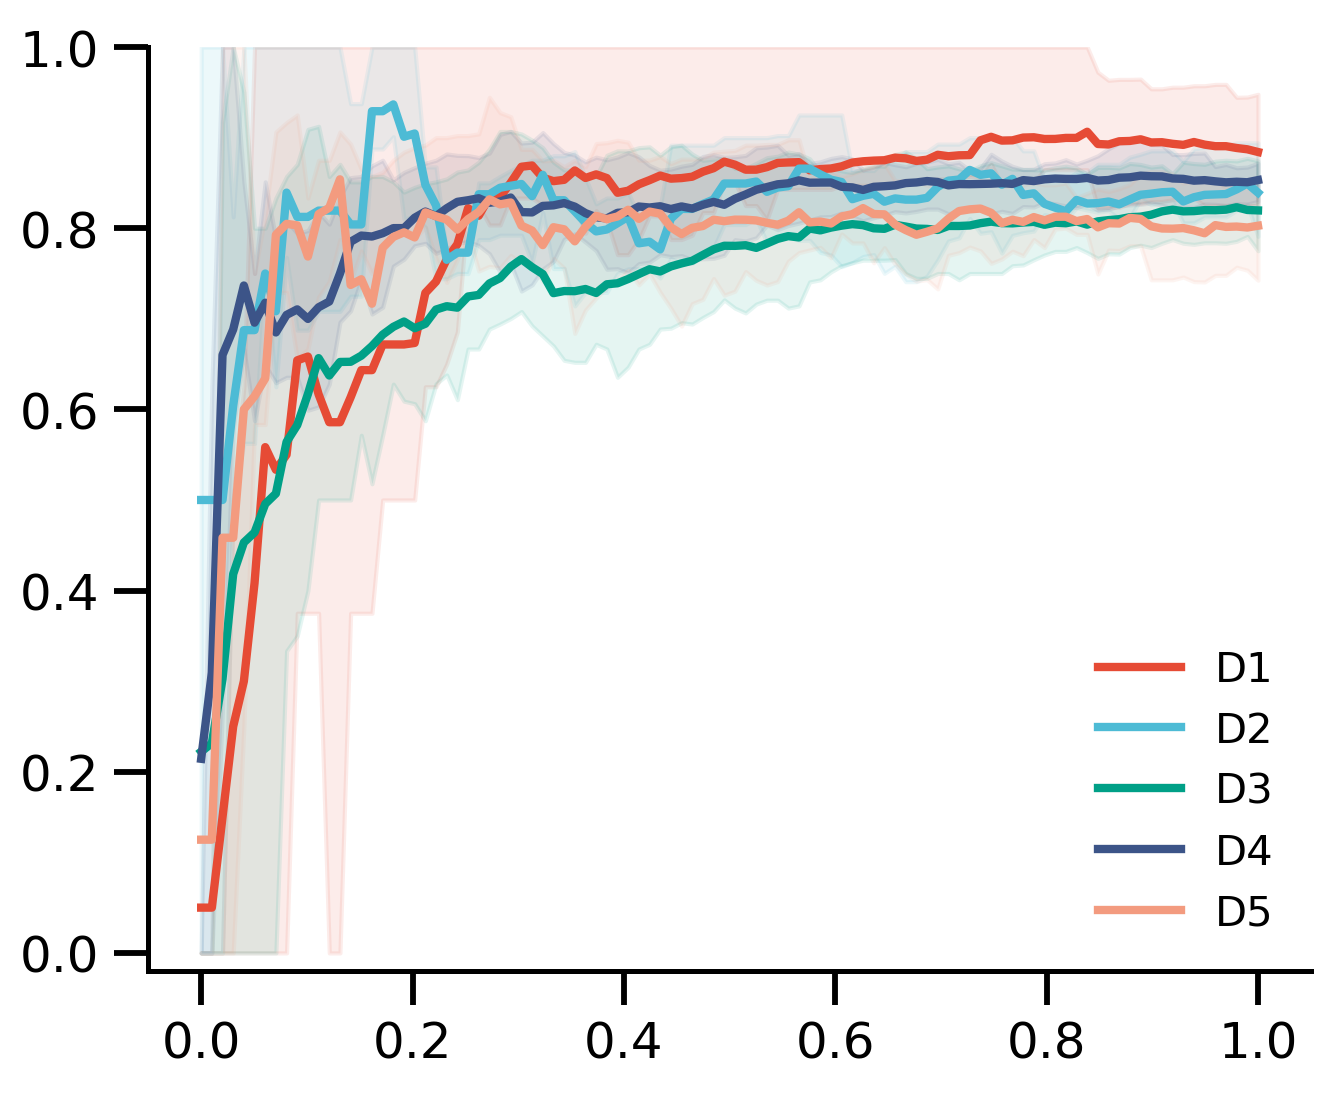

In [46]:
with plt.style.context(spstyle.get_style('nature-reviews')):
    plt.figure(figsize=(5, 4))
    labels = ['D1', 'D2', 'D3', 'D4', 'D5']
    for i, run in enumerate([run_config[0],run_config[1] ,run_config[2], run_config[3], run_config[4]]):
        color = plt.rcParams['axes.prop_cycle'].by_key()['color']
        data = np.nan_to_num(np.array(measure[run['output_dir']]))
        mean_data = np.mean(data, axis=0)
        std_data = np.std(data, axis=0)
        plt.plot(np.linspace(0, 1, n_linear), mean_data[:, 2], color=color[i], label=labels[i])
        plt.fill_between(np.linspace(0, 1, n_linear), np.quantile(data, 0.75, axis=0)[:, 2], np.quantile(data, 0.25, axis=0)[:, 2], color=color[i], alpha=0.1)
        # plt.plot(np.linspace(0, 1, n_linear), mean_data[:, 3], linestyle=':', color=color[i], label=labels[i]+' Pe')
        plt.legend()
        plt.ylim([-0.02, 1])
        plt.xlabel = 'Completion Rate'
        plt.ylabel = 'Score'
        plt.savefig('figures/fig4-self-consistency-score-time.svg', transparent=True)

In [ ]:
scores

In [ ]:
# get the distribution of scores for all available datasets.

START_FRAME = 0
branching_factor = 4
scores = []
groups = []

for root, folders, files in os.walk('../traces'):
    for file in files:
        if file.endswith('mltraces'):
            print(file)
            ref_set = MatlabTraceSet(root + '/' + file)
            print(ref_set)
            ref_set.trim(len(ref_set.time) // 1000 * 1000)
            ref_set.trim(4000, start_frame=START_FRAME)
            if (not ref_set.is_labeled) or (len(ref_set.time) == 0):
                print(file, 'skipped')
                continue
            
            with tf.device('/GPU:0'):
                embedding = embedder.predict(ref_set.to_tensor(), batch_size=32, verbose=-1)
                coeff = get_consistency_coeff(embedding, np.any(ref_set.label, axis=-1), branching_factor)
            del embedding
            del ref_set
            scores.append(coeff)
            if file.startswith('rib'):
                group = 'RiboSwitch'
            elif file.startswith('RNA0'):
                group = 'Pre Q1'
            elif file.startswith('HaMMy'):
                group = 'Swing Arms'
            elif file.startswith('W'):
                group = 'DNA Walker'
            else:
                group = 'N/A'
            groups.append(group)

In [ ]:
scores_array = np.array(scores)
groups_array = np.array(groups)
unique_groups = np.unique(groups)
with plt.style.context(spstyle.get_style('nature-reviews')):
    plt.hist([scores_array[groups_array == g] for g in unique_groups], bins=20, label=unique_groups, range=(0, 1.0))
    plt.legend()
    plt.xlabel('Score')
    plt.ylabel('Counts')

In [ ]:
scores_array = np.array(scores)
groups_array = np.array(groups)
unique_groups = np.unique(groups)
with plt.style.context(spstyle.get_style('nature-reviews')):
    plt.hist([scores_array[groups_array == g] for g in unique_groups], bins=20, label=unique_groups, range=(0, 1.0))
    plt.legend()
    plt.xlabel('Score')
    plt.ylabel('Counts')